# Birankpy Demo

In [59]:
import networkx as nx
import psycopg2
import pandas as pd 
import sqlalchemy as salc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime
import json
import scipy
from networkx.algorithms import bipartite
#from networkx.algorithms import digraph
warnings.filterwarnings('ignore')
import birankpy



In [60]:
with open("config.json") as config_file:
    config = json.load(config_file)

database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

# Getting Actual Augur Network Data

In [61]:
contrib_net = pd.DataFrame()

net_query = salc.sql.text(f"""
            SELECT 
                a.cntrb_id,
                a.repo_id,
                b.repo_name,
                b.repo_git,
                a.login, 
                MAX ( RANK ) AS weight 
            FROM
                explorer_contributor_actions a,
                repo b 
            WHERE
                a.repo_id = b.repo_id -- and a.repo_id = 1
            GROUP BY
                a.cntrb_id,
                a.repo_id,
                b.repo_name,
                b.repo_git,
                a."login"
            ORDER BY
                repo_id;  

                """)

network = pd.read_sql(net_query, con=engine)

display(network)

network.dtypes

,cntrb_id,repo_id,repo_name,repo_git,login,weight
0,25537,1,rails,https://github.com/rails/rails.git,jcoyne,49
1,25566,1,rails,https://github.com/rails/rails.git,jeremyf,8
2,25577,1,rails,https://github.com/rails/rails.git,cbeer,1
3,25635,1,rails,https://github.com/rails/rails.git,twalpole,10
4,25952,1,rails,https://github.com/rails/rails.git,nicolasfranck,1
...,...,...,...,...,...,...
22322,25640,26093,xslt,https://github.com/ropensci/xslt,cboettig,1
22323,25678,26093,xslt,https://github.com/ropensci/xslt,jimhester,3
22324,25717,26093,xslt,https://github.com/ropensci/xslt,zkamvar,1
22325,42393,26093,xslt,https://github.com/ropensci/xslt,oggioniale,1


cntrb_id      int64
repo_id       int64
repo_name    object
repo_git     object
login        object
weight        int64
dtype: object

In [62]:
weighted_edges = (network['cntrb_id'], network['repo_git'], network['weight'])

In [63]:
networker = pd.DataFrame(weighted_edges)
networker = networker.transpose()

In [64]:
networker.cntrb_id.nunique()

16518

In [65]:
networker.repo_git.nunique()

730

In [66]:
bn = birankpy.BipartiteNetwork()

In [67]:
bn.set_edgelist(
    networker,
    top_col='cntrb_id', bottom_col='repo_git',
    weight_col='weight'
)

In [68]:
char_birank_df, _ = bn.generate_birank(normalizer='HITS')


In [69]:
char_birank_df.sort_values(by='cntrb_id_birank', ascending=False).head()

,cntrb_id,cntrb_id_birank
5650,33503,0.187423
6878,35292,0.165801
5743,35302,0.153642
7282,36103,0.048182
6881,35298,0.033599


In [70]:
char_birank_df, _ = bn.generate_birank(normalizer='CoHITS')
char_birank_df.sort_values(by='cntrb_id_birank', ascending=False).head()

,cntrb_id,cntrb_id_birank
5242,25437,0.045981
9938,25447,0.032649
9941,25640,0.013208
12917,25702,0.011408
12222,25735,0.008872


In [71]:
len(char_birank_df)

16518

In [75]:
char_birank_df['rank-z'] = scipy.stats.zscore(char_birank_df['cntrb_id_birank'])

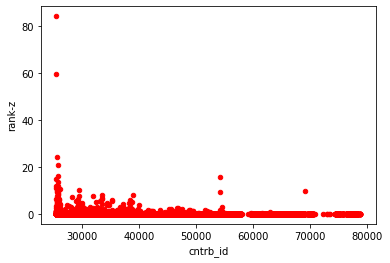

In [76]:
char_birank_df.plot(kind='scatter',x='cntrb_id',y='rank-z',color='red')
plt.show()

In [77]:
print(char_birank_df)

      cntrb_id  cntrb_id_birank    rank-z
0        25537         0.005204  9.431864
1        25566         0.001203  2.094364
2        25577         0.004088  7.384724
3        25635         0.000065  0.009010
4        25952         0.000029 -0.058121
...        ...              ...       ...
16513    51420         0.000021 -0.073392
16514    51442         0.000021 -0.073392
16515    51451         0.000021 -0.073392
16516    51459         0.000032 -0.052425
16517    51433         0.000034 -0.049115

[16518 rows x 3 columns]


In [80]:
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(65)

<Figure size 2160x4680 with 0 Axes>

In [ ]:
char_birank_df.plot(kind='bar',x='cntrb_id',y='rank-z',color='red')
plt.show()